# Table of contents <a name="top"></a>
1. [Introduction](#introduction)
    1. [Importing Packages](#pack)
    2. [Functions](#func)
2. [Toy Example](#toy_example)
    1. [Decision Trees](#dt)
    2. [Boosting](#bt)
3. [Franke's Function](#franke)
4. [Credit Card Data](#cc)
5. [MNIST](#mnist)
    1. [PCA on MNIST 28x28](#pca_mnist)

## Introduction <a name="introduction"></a>
This notebook will test XGBoost on various data sets.

##  importing packages <a name="pack">  
[back to top](#top)

In [179]:
import time
from scipy.io import loadmat
import numpy as np
import pandas as pd
import os
import random
import scipy.linalg as scl
import scikitplot as skplt
import matplotlib.pyplot as plt
import itertools
from PIL import Image

In [180]:
# import sklearn
from sklearn.datasets import fetch_kddcup99,load_digits
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,StratifiedKFold,\
    cross_val_score
from sklearn.metrics import accuracy_score,make_scorer, roc_auc_score,mean_squared_error,r2_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,BaggingRegressor
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [181]:
import xgboost as xgb
from xgboost import XGBClassifier,XGBRFClassifier, XGBRFRegressor,XGBRegressor

In [182]:
import seaborn as sns

## Function definitions <a name="func">  
[back to top](#top)

In [183]:
"""
Function to print the shape of arrays
Usage:
s(array1,array2,...,arrayN)
"""
def s(*arg):
    d=[]
    for i in arg:
        d.append(np.shape(i))
    print(*d, sep=" ")

In [184]:
"""
Function to calculate a persons Body Mass Index
Input:
    he: Height, in centimetres
    w:  Weight, in kilograms
Output:
    returns BMI, a unitless scalar
"""
def BMI(he,w):
    h=he*0.01
    bmi = w/(h*h)
    return np.round(bmi,1)

In [185]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like 
divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [186]:
def sigmoid(s):
    return 1./(1.+np.exp(-s))

In [187]:
#for calculating area ratio as described in Yeh et al
def calc_area_ratio(pred,real):
    fig,ax = plt.subplots(1,1)
    y_te = two(pred)
    skplt.metrics.plot_cumulative_gain(real.ravel(), y_te,ax=ax)
    ax.grid(b=None)
    hh,ll=ax.get_legend_handles_labels()
    plt.close()
    defaults = sum(real == 1)
    total = len(real)
    defaultRate = defaults/total

    bestie=bestCurve(defaults,total,defaultRate)
    dia = np.linspace(0,1,15000)
    classi=hh[1].get_ydata()
    diff_c = np.sum(classi)-np.sum(dia)
    diff_b = np.sum(bestie[1])-np.sum(dia)+1
    area_ratio = diff_c/diff_b
    return area_ratio,hh

In [188]:
def two(y): #helper function for lift curve plotting
    y_two = np.zeros(len(y))
    for i in range(len(y)):
        y_two[i] = 1-y[i]
    return np.c_[y_two,y]

In [189]:
def bestCurve(defaults, total, defaultRate): #create best curve
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

In [190]:
#for plotting lift/gains curve
def plot_lift(h,method):
    backg=np.array(Image.open("/home/janfki/Desktop/ML/Project3/CC_forest.jpg"))

    fig, ax2 = plt.subplots(1,1)
    ax2.plot(h[1].get_xdata(), h[1].get_ydata(),'r--',dashes=(3,3), lw=3, label='fitted curve')
    ax2.legend(loc='right')
    ax2.imshow(backg,aspect='auto',extent=[0,1,0,1.065])

    ax2.set_title(method)
    ax2.set_xlabel('Number of total data',fontweight='bold')
    ax2.set_ylabel('Cumulative number of target data',fontweight='bold')

    ax2.set_xticks((0,0.33,0.66,1))
    ax2.set_xticklabels((0,5000,10000,15000))
    ax2.set_yticks((0,0.15,0.307,0.46,0.614,0.77,0.92,1.065))
    ax2.set_yticklabels((0,500,1000,1500,2000,2500,3000,3500));  
    plt.show()

In [191]:
#for reading of credit card data
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [192]:
# For beautification of pd dataframe
def highlight_cols(x):
    df = x.copy()
    df.loc[:,:]= 'background-color: white'
    df[['BMI']] = 'background-color: #0099ff'
    df[['F0','F1','F2']] = 'background-color : #99d6ff'
    return df

# toy example for theory   <a name="toy_example">  
[back to top](#top)

This example was inspired greatly by
http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

## Decision Trees <a name="dt"> 
[back to top](#top) , 
[back to start of section](#toy_example)

In [5]:
np.random.seed(4)
num_samples = 15
heightses = np.random.normal(loc=180,scale=10,size=num_samples) 
weightses = np.random.normal(loc=75,scale=15,size=num_samples)
swed = np.random.randint(0,2,size=num_samples)
bmi = BMI(heightses,weightses)
gamma=0.5

In [6]:
X = np.c_[heightses.T,weightses.T,swed.T]
y = bmi.T
df1 = pd.DataFrame(np.c_[X,y])
df1.columns = ['H','W','Swedish','BMI']
df1['Swedish'][df1['Swedish']==0.0]='Yes'
df1['Swedish'][df1['Swedish']==1.0]='No'
df = pd.DataFrame(y)
df.columns=['BMI']

### overfit tree

<Figure size 432x288 with 0 Axes>

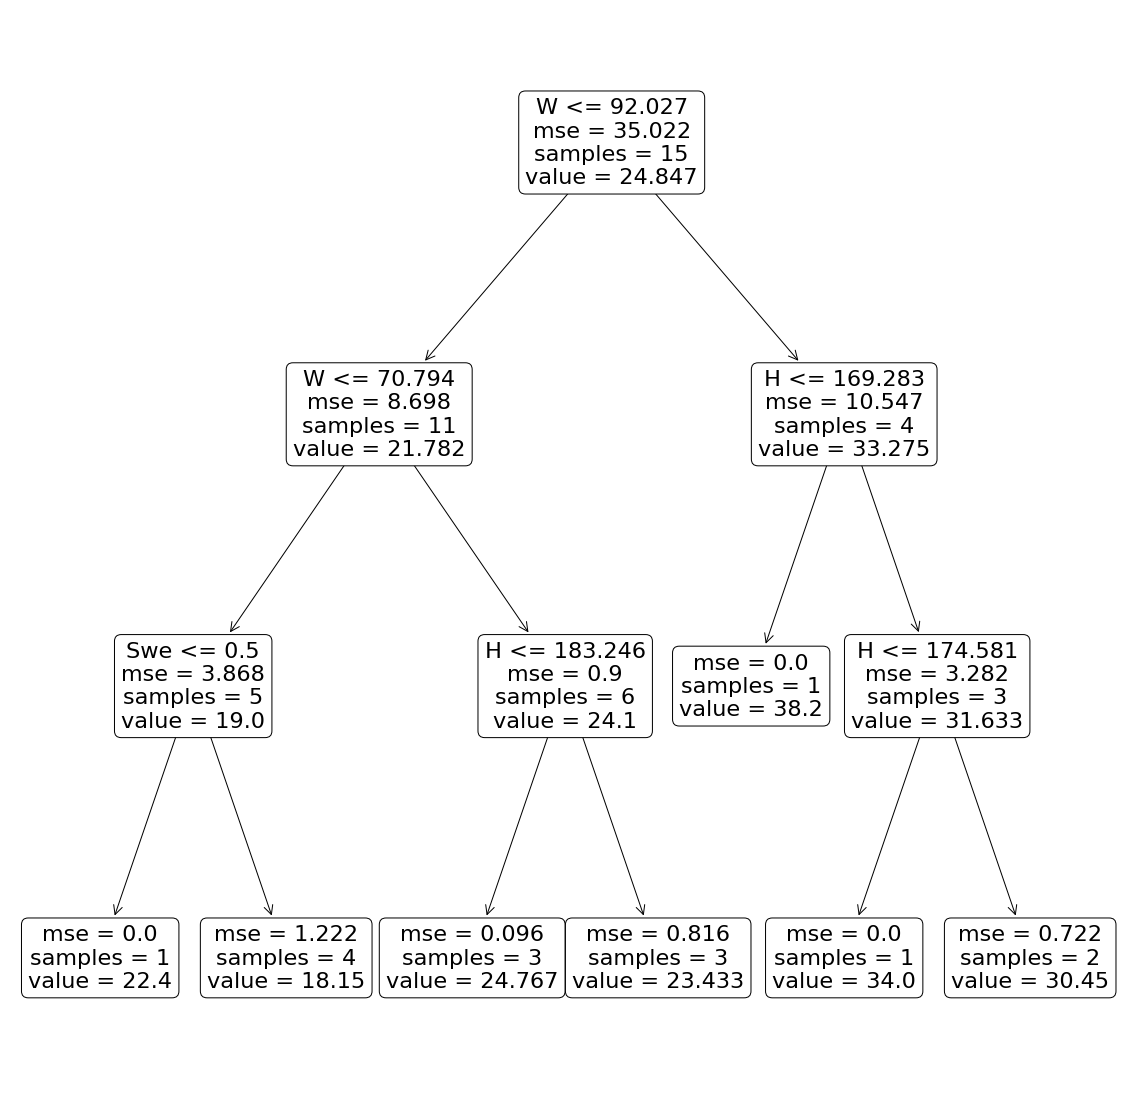

In [7]:
modl = DecisionTreeRegressor(max_depth=3,random_state=42);
modl.fit(X,y);

plt.figure()
fig,ax = plt.subplots(figsize=(20,20))
tree.plot_tree(modl,feature_names=['H','W','Swe'],ax=ax,node_ids=False,rounded=True,rotate=True);
plt.show()

## not overfit tree

<Figure size 432x288 with 0 Axes>

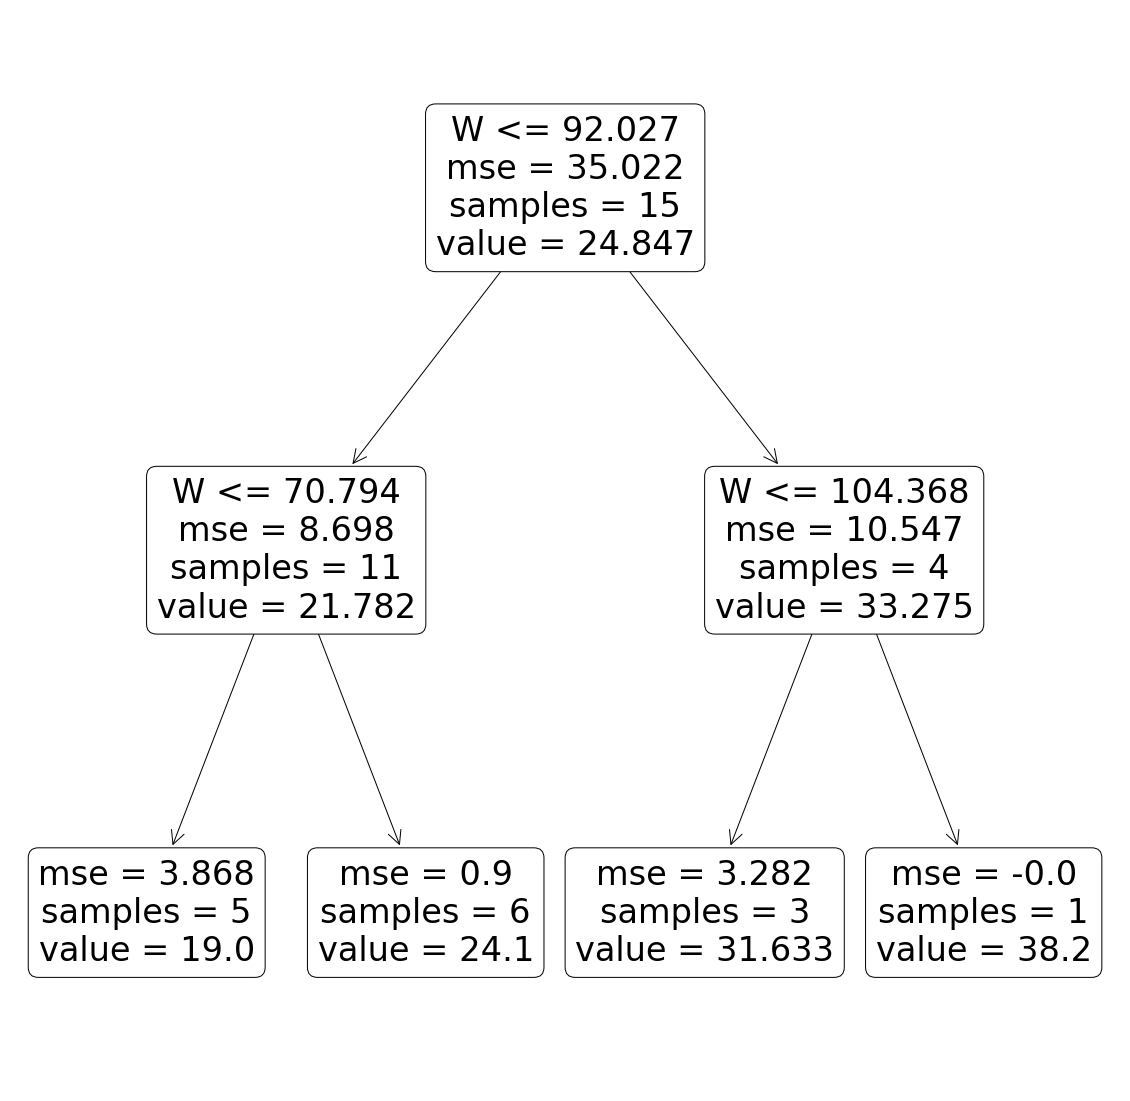

In [8]:
modl = DecisionTreeRegressor(max_depth=2,random_state=42);
modl.fit(X,y);

plt.figure()
fig,ax = plt.subplots(figsize=(20,20))
tree.plot_tree(modl,feature_names=['H','W','Swe'],ax=ax,node_ids=False,rounded=True,rotate=True);
plt.show()

In [9]:
np.random.seed(42)
heightses = np.random.normal(loc=180,scale=10,size=10) 
weightses = np.random.normal(loc=75,scale=15,size=10)
swed = np.random.randint(0,2,size=10)
bmi = BMI(heightses,weightses)
gamma=0.5

In [10]:
X = np.c_[heightses.T,weightses.T,swed.T]
y = bmi.T
df1 = pd.DataFrame(np.c_[X,y])
df1.columns = ['H','W','Swedish','BMI']
df1['Swedish'][df1['Swedish']==0.0]='Yes'
df1['Swedish'][df1['Swedish']==1.0]='No'
df = pd.DataFrame(y)
df.columns=['BMI']

In [11]:
display(df1)
# df1.to_latex(index=False)

,H,W,Swedish,BMI
0,184.967142,68.048735,No,19.9
1,178.617357,68.014054,No,21.3
2,186.476885,78.629434,Yes,22.6
3,195.230299,46.300796,No,12.1
4,177.658466,49.126233,Yes,15.6
5,177.658630,66.565687,No,21.1
6,195.792128,59.807533,Yes,15.6
7,187.674347,79.713710,No,22.6
8,175.305256,61.379639,No,20.0
9,185.425600,53.815444,Yes,15.7


In [12]:
F0 = np.array([bmi.mean() for i in range(len(y))])
PseudoResidual0 = bmi-F0
df['F0'] = F0
df['PR0']=PseudoResidual0

## Boosting <a name="bt"> 
[back to top](#top) , [back to start of section](#toy_example)

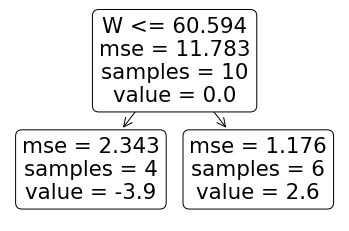

In [13]:
modl = DecisionTreeRegressor(max_depth=1,random_state=42);
modl.fit(X,PseudoResidual0);
tree.plot_tree(modl,feature_names=['H','W','Swe'],node_ids=False,rounded=True);

z = modl.apply(X)

h0 = np.zeros(len(y))
for i in range(len(y)):
    if z[i] == 1:
        h0[i]=round(float(modl.tree_.value[1]),2)
    else:
        h0[i]=round(float(modl.tree_.value[2]),2)
df['h0']=h0

# calc gamma
nod1 = np.argwhere(z==1)
nod2 = np.argwhere(z==2)
bmi1 = bmi[nod1]
bmi2 = bmi[nod2]
FF1 = F0[nod1]
FF2 = F0[nod2]
nod1loss = []
nod2loss = []
linesearch = np.arange(0,100,0.01)
for i in linesearch:
    nod1loss.append(mean_squared_error(bmi1,i*FF1))
    nod2loss.append(mean_squared_error(bmi2,i*FF2))

gamma1 = linesearch[np.argmin(nod1loss)]
gamma2 = linesearch[np.argmin(nod2loss)]
gamma=np.zeros(len(y))
for i in range(len(y)):
    if z[i] == 1:
        gamma[i]=round(gamma1,2)
    else:
        gamma[i]=round(gamma2,2)

In [14]:
F1 = F0+gamma*h0
PseudoResidual1 = bmi-F1
df['gamma0']=gamma
df['F1'] = np.round(F1,2)
df['PR1']=PseudoResidual1

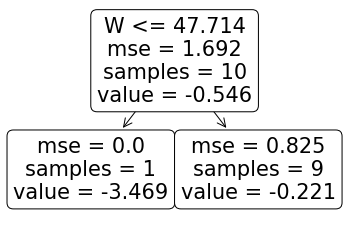

In [15]:
modl = DecisionTreeRegressor(max_depth=1,random_state=42);
modl.fit(X,PseudoResidual1);
tree.plot_tree(modl,feature_names=['H','W','Swe'],node_ids=False,rounded=True);

z = modl.apply(X)
h1 = np.zeros(len(y))

for i in range(len(y)):
    if z[i] == 1:
        h1[i]=round(float(modl.tree_.value[1]),2)
    else:
        h1[i]=round(float(modl.tree_.value[2]),2)
df['h1']=h1

# calc gamma
nod1 = np.argwhere(z==1)
nod2 = np.argwhere(z==2)
bmi1 = bmi[nod1]
bmi2 = bmi[nod2]
FF1 = F0[nod1]
FF2 = F0[nod2]
nod1loss = []
nod2loss = []
linesearch = np.arange(0,100,0.01)
for i in linesearch:
    nod1loss.append(mean_squared_error(bmi1,i*FF1))
    nod2loss.append(mean_squared_error(bmi2,i*FF2))

gamma1 = linesearch[np.argmin(nod1loss)]
gamma2 = linesearch[np.argmin(nod2loss)]
gamma=np.zeros(len(y))
for i in range(len(y)):
    if z[i] == 1:
        gamma[i]=round(gamma1,2)
    else:
        gamma[i]=round(gamma2,2)

In [16]:
F2 = F1+gamma*h1
df['gamma1']=gamma
df['F2'] = np.round(F2,2)

In [18]:
df.style.apply(highlight_cols,axis=None)
# df.to_latex(index=False)

,BMI,F0,PR0,h0,gamma0,F1,PR1,h1,gamma1,F2
0,19.9,18.65,1.25,2.6,1.14,21.61,-1.714,-0.22,1.04,21.39
1,21.3,18.65,2.65,2.6,1.14,21.61,-0.314,-0.22,1.04,21.39
2,22.6,18.65,3.95,2.6,1.14,21.61,0.986,-0.22,1.04,21.39
3,12.1,18.65,-6.55,-3.9,0.79,15.57,-3.469,-3.47,0.65,13.31
4,15.6,18.65,-3.05,-3.9,0.79,15.57,0.031,-0.22,1.04,15.34
5,21.1,18.65,2.45,2.6,1.14,21.61,-0.514,-0.22,1.04,21.39
6,15.6,18.65,-3.05,-3.9,0.79,15.57,0.031,-0.22,1.04,15.34
7,22.6,18.65,3.95,2.6,1.14,21.61,0.986,-0.22,1.04,21.39
8,20,18.65,1.35,2.6,1.14,21.61,-1.614,-0.22,1.04,21.39
9,15.7,18.65,-2.95,-3.9,0.79,15.57,0.131,-0.22,1.04,15.34


# FUN WITH THE FRANKE FUNCTION <a name="franke"></a>  
[back to top](#top)

### Create data

In [162]:
#creating 2 datasets instead of doing train test split for ease of plotting.

################
### TRAINING ###
################

N = 150 #number of points along x and y axes
np.random.seed(42)
# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)
X_matr = np.c_[np.matrix.flatten(x),np.matrix.flatten(y),z_n]
np.random.shuffle(X_matr)
Xshuf,yshuf = X_matr[:,:2],X_matr[:,2]

############
### TEST ###
############

N2=20
# sort this for meshgrid
x2 = np.sort(np.random.uniform(0,1,N2))
y2 = np.sort(np.random.uniform(0,1,N2))
x2, y2 = np.meshgrid(x2,y2,sparse=False)

#create datapoints/results
z2 = FrankeFunction(x2, y2)

# Create noise
noise_weight2 = 0.1
Noise2 = noise_weight2*np.random.randn(N2,N2)

#add noise
z_noise2 = z2+Noise2

#flatten for use in functions
z_n2 = np.matrix.flatten(z_noise2)
X_matr2 = np.c_[np.matrix.flatten(x2),np.matrix.flatten(y2),z_n2]
np.random.shuffle(X_matr2)
Xshuf2,yshuf2 = X_matr2[:,:2],X_matr2[:,2]

xtr,ytr,xte,yte = Xshuf[:,:2],yshuf[:],Xshuf2[:,:2],yshuf2[:]

In [164]:
##################
### VALIDATION ###
##################

N3=20
# sort this for meshgrid
np.random.seed(66)
x3 = np.sort(np.random.uniform(0,1,N3))
y3 = np.sort(np.random.uniform(0,1,N3))
x3, y3 = np.meshgrid(x3,y3,sparse=False)

#create datapoints/results
z3 = FrankeFunction(x3, y3)

# Create noise
noise_weight3 = 0.1
Noise3 = noise_weight3*np.random.randn(N3,N3)

#add noise
z_noise3 = z3+Noise3

#flatten for use in functions
z_n3 = np.matrix.flatten(z_noise3)
X_matr3 = np.c_[np.matrix.flatten(x3),np.matrix.flatten(y3),z_n3]
np.random.shuffle(X_matr3)
Xshuf3,yshuf3 = X_matr3[:,:2],X_matr3[:,2]

xv,yv = Xshuf3[:,:2],yshuf3[:] ##this looks silly, fix when grdsearch stops

### Perform regression

In [163]:
xgbr = XGBRegressor(objective='reg:squarederror',seed=42)
xgbr.fit(xtr,ytr)
print("R2 - test",round(xgbr.score(xte,yte),7))
print("R2 -train",round(xgbr.score(xtr,ytr),7))
tr_pred = xgbr.predict(xtr)
te_pred = xgbr.predict(xte)
print("MSE- test",round(mean_squared_error(te_pred,yte),7))
print("MSE-train",round(mean_squared_error(tr_pred,ytr),7))

/home/janfki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


R2 - test 0.8851414
R2 -train 0.8930354
MSE- test 0.0100607
MSE-train 0.0103985


### Perform gridsearch for best parameter values

In [167]:
franke_params = {
    'max_depth':[2,3,4,5,6,7,8],
    'learning_rate':[0.5,0.1,0.001],
    'lambda':[0,2,5],
    'n_estimators':[100,200,300,400,500],
    'gamma':[0],
    'min_child_weight':[1.5],
    'subsample':[0.6,0.6,1.0],
}

model = XGBRegressor(objective='reg:squarederror',seed=42)
gs = GridSearchCV(model,franke_params,cv=5)
gs.fit(xtr,ytr)
gs.get_params()
y_pr = gs.predict(xte)
y_pr_v=gs.predict(xv)
print(r2_score(y_pr,yte))
print(r2_score(y_pr_v,yv))

/home/janfki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


0.883181118831966
0.8898225580441564


### Best result (hand tuned)

In [177]:
dtrain = xgb.DMatrix(xtr,ytr)
dtest=xgb.DMatrix(xte,yte)
dval = xgb.DMatrix(xv,yv)
params={
    'max_depth': 8,
    'learning_rate':0.05,
    'gamma':0,
    'min_child_weight':1.5,
    'objective':'reg:squarederror',
    'n_estimators':400,
    'seed':42,
    'subsample':0.6,
}
params['eval_metric']='rmse'
num_boost_round=63 
model = xgb.train(params,dtrain,num_boost_round=num_boost_round,
                 evals=[(dtrain,'Train'),(dtest,'Test')],
                 early_stopping_rounds=200, verbose_eval=False)
print("Best MSE: {}, found at iteration: {}".format(model.best_score**2,model.best_iteration+1))
y_te_pr = model.predict(dtest)
y_tr_pr = model.predict(dtrain)
y_v_pr = model.predict(dval)
print("R2 - val",round(r2_score(yv,y_v_pr),7))
print("R2 - test",round(r2_score(yte,y_te_pr),7))
print("R2 -train",round(r2_score(ytr,y_tr_pr),7))
print("MSE- val",round(mean_squared_error(y_v_pr,yv),7))
print("MSE- test",round(mean_squared_error(y_te_pr,yte),7))
print("MSE-train",round(mean_squared_error(y_tr_pr,ytr),7))

/home/janfki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


Best MSE: 0.009705599288999998, found at iteration: 63
R2 - val 0.9026183
R2 - test 0.8891948
R2 -train 0.9048811
MSE- val 0.0103971
MSE- test 0.0097057
MSE-train 0.0092469


### Bagging test  
http://web.engr.oregonstate.edu/~tgd/publications/mlj-randomized-c4.pdf  
indicates that AdaBoost performs poorly on noisy data, and that bagging works better.  
As XGBoost performed rather poorly on this data, a quick test of bagging is performed.  
The results were even worse.

In [166]:
dtparams={
#     'max_depth':7
}
bags = BaggingRegressor(
                        DecisionTreeRegressor(**dtparams),
#                         bootstrap_features=False,
                        n_estimators = 2000,
#                         oob_score=True,
                        warm_start=True,
                        max_samples=0.001,
                        n_jobs=-1,
                        random_state=42
                       )
bags.fit(xtr,ytr)
print(bags.score(xte,yte))
print(bags.score(xtr,ytr))

0.8635269280536786
0.8455634037543333


# Revisiting the creditcard data set <a name="cc"></a>  
[back to top](#top)

In [193]:
X_train_cc, X_test_cc, y_train_cc, y_test_cc = ReadData()

### weighing data due to biased dataset?  
This seems not to have mattered for this set, possibly more relevant for data with higher bias?

In [195]:
test_size = len(y_test_cc)

label  = y_train_cc
data   = X_train_cc
weight = y_train_cc * float(test_size) / len(label)

sum_wpos = sum( 1 for i in range(len(label)) if label[i] == 1.0  )
sum_wneg = sum( 1 for i in range(len(label)) if label[i] == 0.0  )
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

dtrain_cc = xgb.DMatrix(X_train_cc, y_train_cc)#,weight=weight)
dtest_cc = xgb.DMatrix(X_test_cc, y_test_cc)


# scale_pos_weight [default=1]

weight statistics: wpos=3318, wneg=11682, ratio=3.5208


# first with no parameter tuning

error - test 0.18
error -train 0.17
area ratio - test 0.56
area ratio - train 0.62


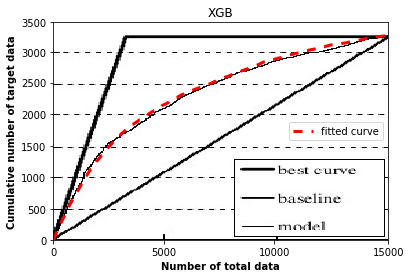

In [199]:
xgbc = XGBClassifier(objective='binary:logistic',eval_metric='error',seed=42)
xgbc.fit(X_train_cc,y_train_cc)

print("error - test",round(1.0-xgbc.score(X_test_cc,y_test_cc),2))
print("error -train",round(1.0-xgbc.score(X_train_cc,y_train_cc),2))

y_pr_te_cc = xgbc.predict(X_test_cc,output_margin=True)
yyy_te = sigmoid(y_pr_te_cc)
# print(yyy_te)
y_pr_tr_cc = xgbc.predict(X_train_cc,output_margin=True)
yyy_tr = sigmoid(y_pr_tr_cc)
print("area ratio - test",round(calc_area_ratio(yyy_te,y_test_cc)[0],2))
print("area ratio - train",round(calc_area_ratio(yyy_tr,y_train_cc)[0],2))

plot_lift(calc_area_ratio(y_pr_te_cc.T, y_test_cc)[1],'XGB')

# play w param here

R2 - test 0.181
R2 -train 0.173
area ratio - test 0.566
area ratio - train 0.61


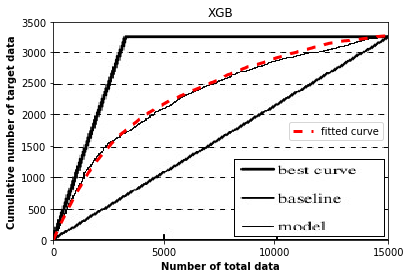

In [203]:
classifier_params = {
#     'eta':0.05,
    'max_depth':5,
    'objective':'binary:logistic',
#     'min_child_weight':2,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'lambda':50.,
    'alpha':20.,
#     'gamma':10.,
#     'colsample_bylevel':0.8,
    'eval_metric':'error',
    'seed':42,
}
evallist=[(dtrain_cc,'train'),(dtest_cc,'test')]
num_round=200
early_stopping=20
bst=xgb.train(classifier_params, dtrain_cc, num_round, evallist, \
              early_stopping_rounds = early_stopping, verbose_eval=False
             )

r2test =bst.eval(dtest_cc,iteration=bst.best_iteration).split(":")
r2train = bst.eval(dtrain_cc,iteration = bst.best_iteration).split(":")
print("R2 - test",round(float(r2test[1]),3))
print("R2 -train",round(float(r2train[1]),3))

y_pr_te_cc2 = bst.predict(dtest_cc,output_margin=True)
yyy_te2 = sigmoid(y_pr_te_cc2)
y_pr_tr_cc2 = bst.predict(dtrain_cc,output_margin=True)
yyy_tr2 = sigmoid(y_pr_tr_cc2)
print("area ratio - test",round(calc_area_ratio(yyy_te2,y_test_cc)[0],3))
print("area ratio - train",round(calc_area_ratio(yyy_tr2,y_train_cc)[0],3))

plot_lift(calc_area_ratio(y_pr_te_cc2.T, y_test_cc)[1],'XGB')

# PCA

In [204]:
from sklearn.decomposition import PCA
n_comp = 18
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(X_train_cc)
X2Dt = pca.transform(X_test_cc)

dtrainpca= xgb.DMatrix(X2D,y_train_cc)
dtestpca= xgb.DMatrix(X2Dt,y_test_cc)

### Default param

/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


error - test 0.183
error -train 0.169
area ratio - test 0.545
area ratio - train 0.612


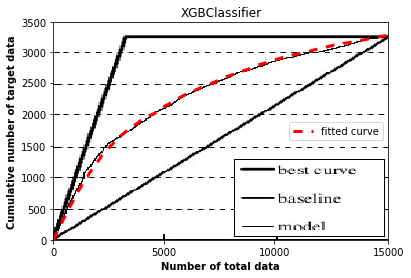

In [205]:
xgbc = XGBClassifier(objective='binary:logistic',eval_metric='error',seed=42)
xgbc.fit(X2D,y_train_cc)
print("error - test",round(1.0-xgbc.score(X2Dt,y_test_cc),3))
print("error -train",round(1.0-xgbc.score(X2D,y_train_cc),3))

y_pr_te_cc = xgbc.predict(X2Dt,output_margin=True)
yyy_te = sigmoid(y_pr_te_cc)
y_pr_tr_cc = xgbc.predict(X2D,output_margin=True)
yyy_tr = sigmoid(y_pr_tr_cc)

print("area ratio - test",round(calc_area_ratio(yyy_te,y_test_cc)[0],3))
print("area ratio - train",round(calc_area_ratio(yyy_tr,y_train_cc)[0],3))

plot_lift(calc_area_ratio(y_pr_te_cc.T, y_test_cc)[1],'XGBClassifier')

### Optimized param

In [206]:
classifier_params = {
    'eta':0.05,
    'max_depth':60,
    'objective':'binary:logistic',
    'min_child_weight':5,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'lambda':10.,
    'alpha':10.,
    'gamma':10.,
    'colsample_bylevel':0.8,
    'eval_metric':'error',
}
evallist=[(dtrainpca,'train'),(dtestpca,'test')]

num_round=200
early_stopping=20


bst=xgb.train(classifier_params, dtrainpca, num_round, evallist, \
              early_stopping_rounds = early_stopping, verbose_eval=False
             )


y_pred_cc = bst.predict(dtestpca,ntree_limit=num_round,output_margin=True)
y_pred_cc_tr = bst.predict(dtrainpca,ntree_limit=num_round)

error - test 0.2
error -train 0.18
area ratio - test 0.54
area ratio - train 0.57


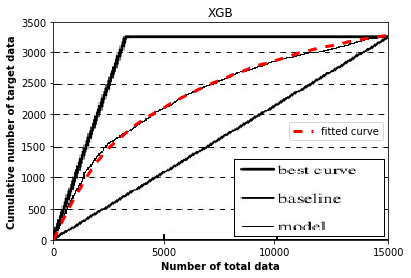

In [207]:
yt_binary = np.copy(y_pred_cc)
ytr_binary = np.copy(y_pred_cc_tr)
yt_binary[yt_binary>0.5]=1
yt_binary[yt_binary<=0.5]=0
ytr_binary[ytr_binary>0.5]=1
ytr_binary[ytr_binary<=0.5]=0
print("error - test",round(1-accuracy_score(yt_binary,y_test_cc),2))
print("error -train",round(1.0-accuracy_score(ytr_binary,y_train_cc),2))

print("area ratio - test",round(calc_area_ratio(y_pred_cc,y_test_cc)[0],2))
print("area ratio - train",round(calc_area_ratio(y_pred_cc_tr,y_train_cc)[0],2))

plot_lift(calc_area_ratio(y_pred_cc.T, y_test_cc)[1],'XGB')

In [208]:
print(confusion_matrix(yt_binary,y_test_cc))

[[11455  2705]
 [  227   613]]


# MNIST <a name="mnist">  
[back to top](#top)

### 8x8 data set

0.0 16.0


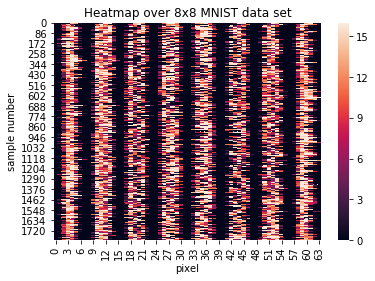

In [210]:
# import 8x8 dataset
numbers = load_digits()
X = numbers.data
y = numbers.target
#ADD SOME NOISE HERE IF WANTED!
print(X.min(),X.max())

plt.figure()
sns.heatmap(X)
plt.xlabel('pixel')
plt.ylabel('sample number')
plt.title('Heatmap over 8x8 MNIST data set')
plt.show()

### split in train test

(1437, 64) (1437,)
(360, 64) (360,)


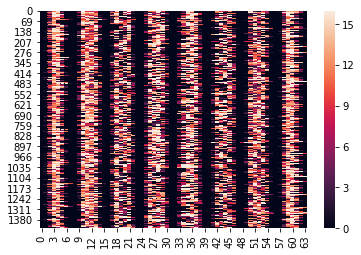

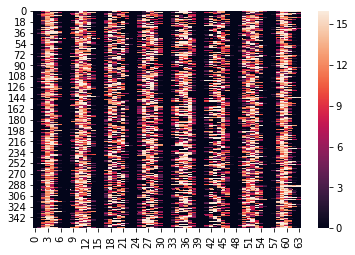

In [212]:
test_size=0.2
X_train_,X_test_,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=2,shuffle=True,stratify=y)

s(X_train_,y_train)
s(X_test_,y_test)
plt.figure()
sns.heatmap(X_train_)
plt.show()
plt.figure()
sns.heatmap(X_test_)
plt.show()

Note the completely black bands/columns in the data!  
This indicates to me that many features will always be the same color, and thus useless.  
Removing these should yield similar results in a much shorter time, so the MNIST data set is a prime candidate for PCA.  
This will be explored a little later.

### Scale data  
This shouldn't matter for trees

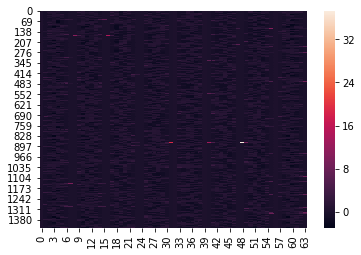

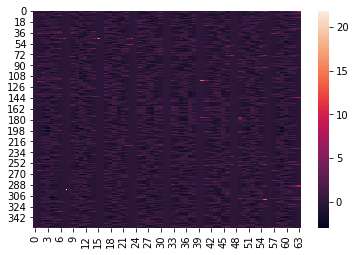

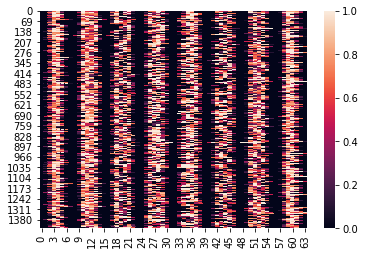

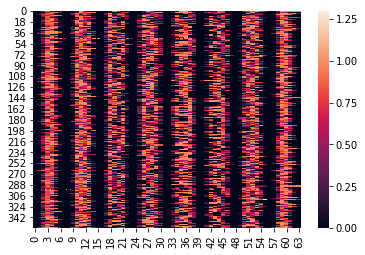

In [213]:
## standard scaler

sc = StandardScaler()
X_train2 = sc.fit_transform(X_train_)
X_test2 = sc.transform(X_test_)

plt.figure()
sns.heatmap(X_train2)
plt.show()
plt.figure()
sns.heatmap(X_test2)
plt.show()

## MinMax scaler

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train_)
X_test = mms.transform(X_test_)

plt.figure()
sns.heatmap(X_train)
plt.show()
plt.figure()
sns.heatmap(X_test)
plt.show()

### Test XGBClassifier

In [214]:
# SCALED WITH MINMAXSCALER
ting={'eval_metric':'merror'}
xgbc = XGBClassifier(
    n_estimators=400,
    booster='gbtree',
    objective='multi:softmax',
    num_class=10,**ting,
    )
start=time.time()
xgbc.fit(X_train,y_train)
scores=cross_val_score(xgbc,X_train,y_train,cv=10,n_jobs=-1)
print("this took {}s.".format(time.time()-start))
print("CV:",scores.mean())
print("test acc",xgbc.score(X_test,y_test))

# UNSCALED DATA
ting={'eval_metric':'merror'}
xgbc = XGBClassifier(
    n_estimators=400,
    booster='gbtree',
    objective='multi:softmax',
    num_class=10,**ting,
    )
start=time.time()
xgbc.fit(X_train_,y_train)
scores=cross_val_score(xgbc,X_train_,y_train,cv=10,n_jobs=-1)
print("this took {}s.".format(time.time()-start))
print("CV:",scores.mean())
print("test acc",xgbc.score(X_test_,y_test))

# SCALED WITH STANDARD SCALER
ting={'eval_metric':'merror'}
xgbc = XGBClassifier(
    n_estimators=400,
    booster='gbtree',
    objective='multi:softmax',
    num_class=10,**ting,
    random_state=42,
    )
start=time.time()
xgbc.fit(X_train2,y_train)
scores=cross_val_score(xgbc,X_train2,y_train,cv=10,n_jobs=-1)
print("this took {}s.".format(time.time()-start))
print("CV:",scores.mean())
print("test acc",xgbc.score(X_test2,y_test))


this took 25.604612350463867s.
CV: 0.9678665234229322
test acc 0.9666666666666667
this took 26.244149923324585s.
CV: 0.9678665234229322
test acc 0.9666666666666667
this took 26.156450748443604s.
CV: 0.9678665234229322
test acc 0.9666666666666667


As expected, scaling doesn't matter for prediction.    
Sticking witn min-max scaled data, as its a bit prettier

### Using XGBoosts own XGBtrain, not the skl-like XGBClassifier

Accuracy score: 0.9555555555555556


<Figure size 432x288 with 0 Axes>

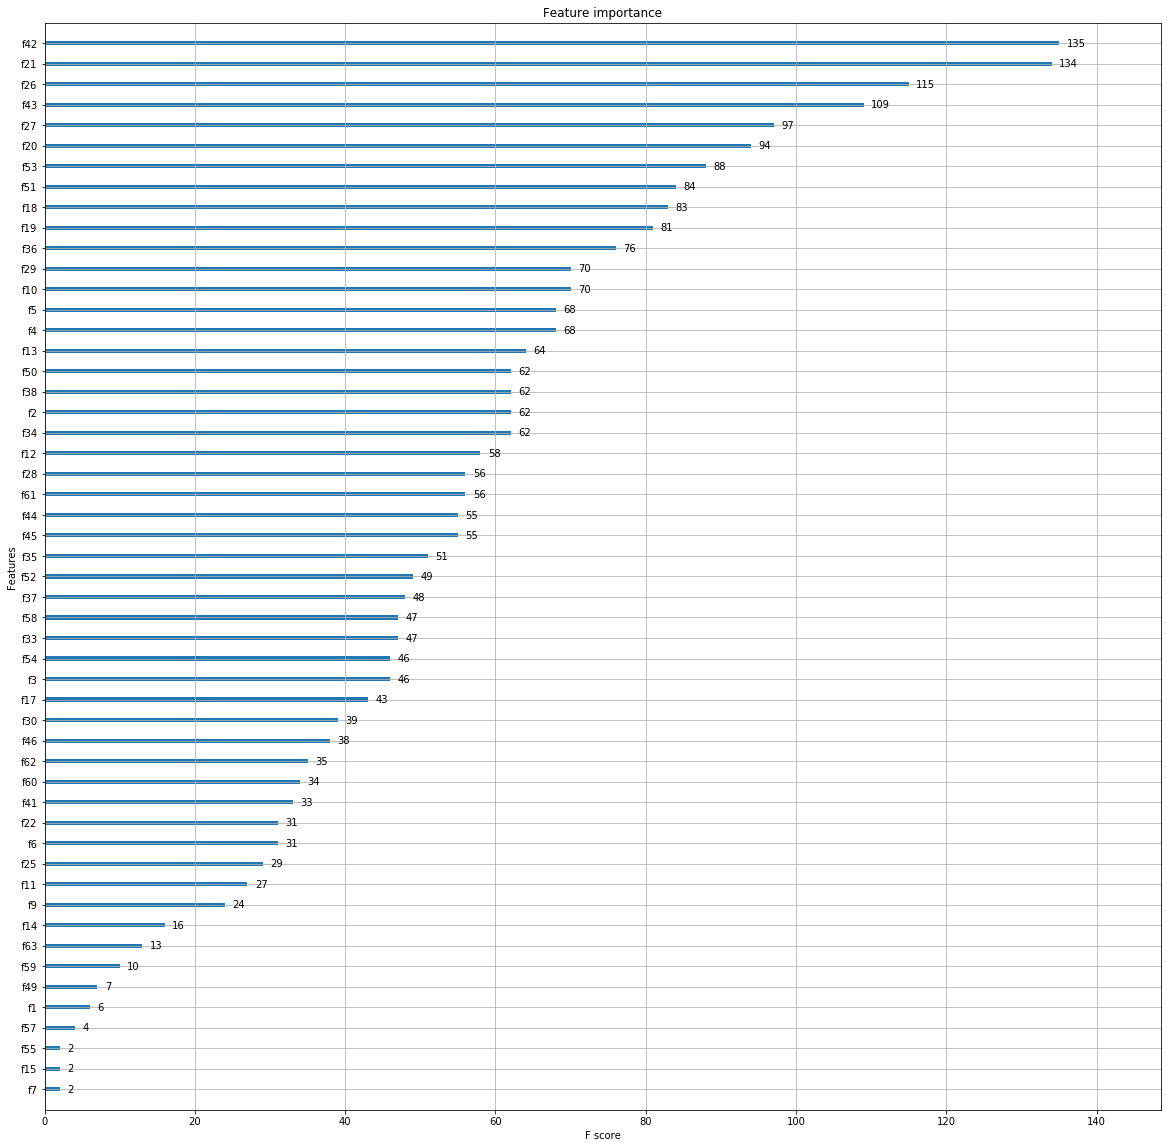

<Figure size 432x288 with 0 Axes>

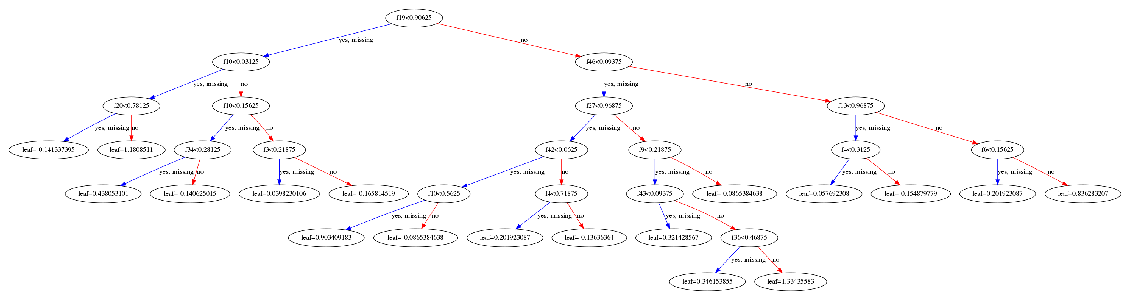

In [215]:
# when using xgboost, the data should be put into a Data Matrix structure, seen in
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix
D_train = xgb.DMatrix(X_train,label=y_train)
D_test = xgb.DMatrix(X_test,label=y_test)
classifier_params = {
#     'eta':0.1,
#     'max_depth':3,
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(D_train,'train'),(D_test,'test')]

num_round=100
early_stopping=10

# Set verbose_eval=True below to see train and test scores for each round.
bst=xgb.train(classifier_params,D_train,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
y_pred=bst.predict(D_test)
print("Accuracy score:",accuracy_score(y_test,y_pred))


plt.figure()
fig,ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(bst,ax=ax)
plt.show()

plt.figure()
fig,ax = plt.subplots(figsize=(20,20))
xgb.plot_tree(bst,num_trees=1,ax=ax)
plt.show()

### look at feature importance  
Also some exploratory data analysis to see if PCA might be good for this data

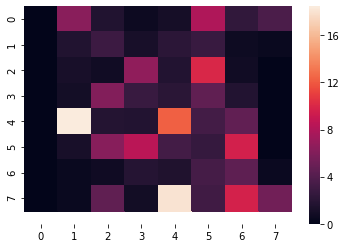

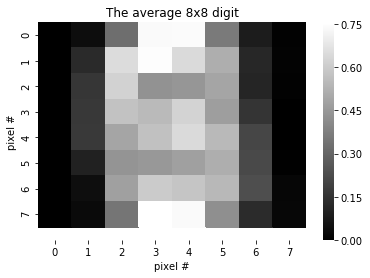

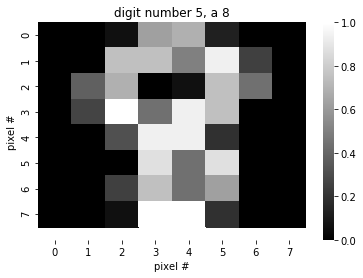

In [217]:
a=bst.get_score(importance_type='gain')
    
for i in range(0,8*8): #fill dict
    if 'f'+str(i) not in a:
        a['f'+str(i)]=0
fisk = np.zeros(8*8)

for i in range(0,8*8):
    fisk[i] = a['f'+str(i)]

u=fisk.reshape(8,8)
plt.figure()
ax=sns.heatmap(u)
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.show()

# This indicates we can cut at least 16 or so features? left and rightmost columns
XXX = X_train.mean(axis=0)
XX=XXX.reshape(8,8);
plt.figure()
ax=sns.heatmap(XX,cmap='binary_r')
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.xlabel('pixel #')
plt.ylabel('pixel #')
plt.title("The average 8x8 digit")
plt.show()

digit_n = 5
XXX = X_train[digit_n,:]
XX=XXX.reshape(8,8);
plt.figure()
ax=sns.heatmap(XX,cmap='binary_r')
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.xlabel('pixel #')
plt.ylabel('pixel #')
plt.title("digit number {}, a {}".format(digit_n,int(y_train[digit_n])))
plt.show()

## PCA on MNIST28x28   <a name="pca_mnist"> 
[back to top](#top), [back to start of section](#mnist)

1 of 64
2 of 64
3 of 64
4 of 64
5 of 64
6 of 64
7 of 64
8 of 64
9 of 64
10 of 64
11 of 64
12 of 64
13 of 64
14 of 64
15 of 64
16 of 64
17 of 64
18 of 64
19 of 64
20 of 64
21 of 64
22 of 64
23 of 64
24 of 64
25 of 64
26 of 64
27 of 64
28 of 64
29 of 64
30 of 64
31 of 64
32 of 64
33 of 64
34 of 64
35 of 64
36 of 64
37 of 64
38 of 64
39 of 64
40 of 64
41 of 64
42 of 64
43 of 64
44 of 64
45 of 64
46 of 64
47 of 64
48 of 64
49 of 64
50 of 64
51 of 64
52 of 64
53 of 64
54 of 64
55 of 64
56 of 64
57 of 64
58 of 64
59 of 64
60 of 64
61 of 64
62 of 64
63 of 64


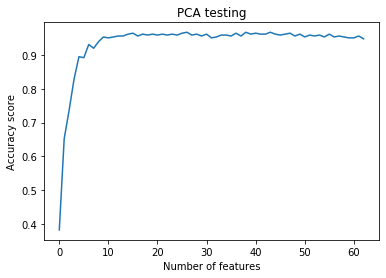

In [218]:
test_accuracy_=[]
classifier_params = {
    'objective':'multi:softmax',
    'num_class':10,
}
num_round=100
early_stopping=10

for i in range(1,X_train.shape[1]):
    print("{} of {}".format(i,X_train.shape[1]))
    n_comp = i
    pca = PCA(n_components=n_comp)
    X2D = pca.fit_transform(X_train)
    X2Dt = pca.transform(X_test)
    D_train = xgb.DMatrix(X2D,label=y_train)
    D_test = xgb.DMatrix(X2Dt,label=y_test)
    evallist=[(D_train,'train'),(D_test,'test')]

    bst=xgb.train(classifier_params,D_train,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
    y_pred=bst.predict(D_test)

    test_accuracy_.append(accuracy_score(y_test, y_pred))

plt.figure()
plt.plot(test_accuracy_)
plt.title("PCA testing")
plt.xlabel("Number of features")
plt.ylabel("Accuracy score")
plt.show()

### Gridsearch

In [219]:
xgb_model = XGBClassifier()
opt_dict={
    'max_depth':[2,3,4],
    'eta': np.logspace(-3,1,5),
    'lambda': np.logspace(-7,1,8),
    'alpha':np.logspace(-7,1,8),
}
mod = GridSearchCV(xgb_model,opt_dict,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
mod.fit(X_train,y_train)
print(mod.best_score_)
print(mod.best_params_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 40.8min finished


0.9624217118997912
{'alpha': 1e-07, 'eta': 0.001, 'lambda': 1e-07, 'max_depth': 4}


### some results

,0,1,2,3,4,5,6,7,8,9
0,3,0,1,0,0,0,0,0,0,0
1,0,3,1,1,1,0,1,0,1,0
2,0,1,3,0,0,0,0,0,0,0
3,0,0,0,3,0,0,0,0,0,0
4,1,0,0,0,3,0,0,0,0,0
5,1,0,0,1,0,3,0,0,0,0
6,0,0,0,0,0,0,3,0,0,0
7,0,0,0,0,0,0,0,3,0,1
8,0,0,0,0,0,1,1,0,3,0
9,0,1,0,0,1,3,0,0,1,3


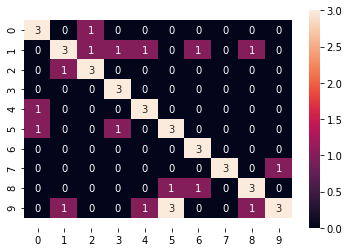

This is a: 6
Predicted as a: 9


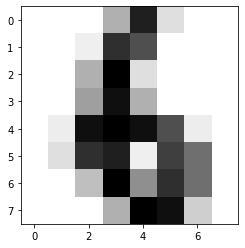

In [222]:
y_p = mod.predict(X_test)
ape = confusion_matrix(y_p,y_test)
df = pd.DataFrame(ape)

np.fill_diagonal(df.values,0)
ultros=np.max(np.max(df))
np.fill_diagonal(df.values,ultros)

# print(ultros)
display(df)
ax = sns.heatmap(df,annot=True)
bottom,top =ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.show()

num = 7
plt.imshow(X_train[num,:].reshape(8,8),cmap='gray_r')
print("This is a:",y_train[num])
print("Predicted as a:",int(y_pred[num]))

# Full size MNIST, 28x28 pixels

### fetch mnist data

In [223]:
from sklearn.datasets import fetch_mldata,fetch_openml
# mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
mnist=fetch_openml('mnist_784')

X_full = mnist.data
y_full = mnist.target
s(X_full,y_full)

(70000, 784) (70000,)


### Get MNIST data from file

In [ ]:
# data = loadmat('mnist-original.mat')
# X_full = data['data'].T
# y_full = np.squeeze(data['label'].T)
# s(X_full,y_full)

### Train test split

In [224]:
test_size=0.2
X_train_784,X_test_784,y_train_784,y_test_784 = train_test_split(X_full,y_full,test_size=test_size,random_state=2)#,stratify=y)

### First classification attempt

In [225]:
model = XGBClassifier()
model.fit(X_train_784,y_train_784)
y_pred_classifier = model.predict(X_test_784)

print(accuracy_score(y_test_784,y_pred_classifier))

0.9356428571428571


### Second attempt

[0]	test-merror:0.309429	train-merror:0.301554
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 10 rounds.
[1]	test-merror:0.244714	train-merror:0.241321
[2]	test-merror:0.218714	train-merror:0.213429
[3]	test-merror:0.202786	train-merror:0.199339
[4]	test-merror:0.187571	train-merror:0.187911
[5]	test-merror:0.184143	train-merror:0.183589
[6]	test-merror:0.177214	train-merror:0.175571
[7]	test-merror:0.170357	train-merror:0.1705
[8]	test-merror:0.166286	train-merror:0.166196
[9]	test-merror:0.161143	train-merror:0.162
[10]	test-merror:0.158	train-merror:0.157286
[11]	test-merror:0.156071	train-merror:0.153607
[12]	test-merror:0.151571	train-merror:0.149625
[13]	test-merror:0.1485	train-merror:0.146946
[14]	test-merror:0.145	train-merror:0.143339
[15]	test-merror:0.142714	train-merror:0.140625
[16]	test-merror:0.14	train-merror:0.138089
[17]	test-merror:0.138429	train-merror:0.136232
[18]	test-merr

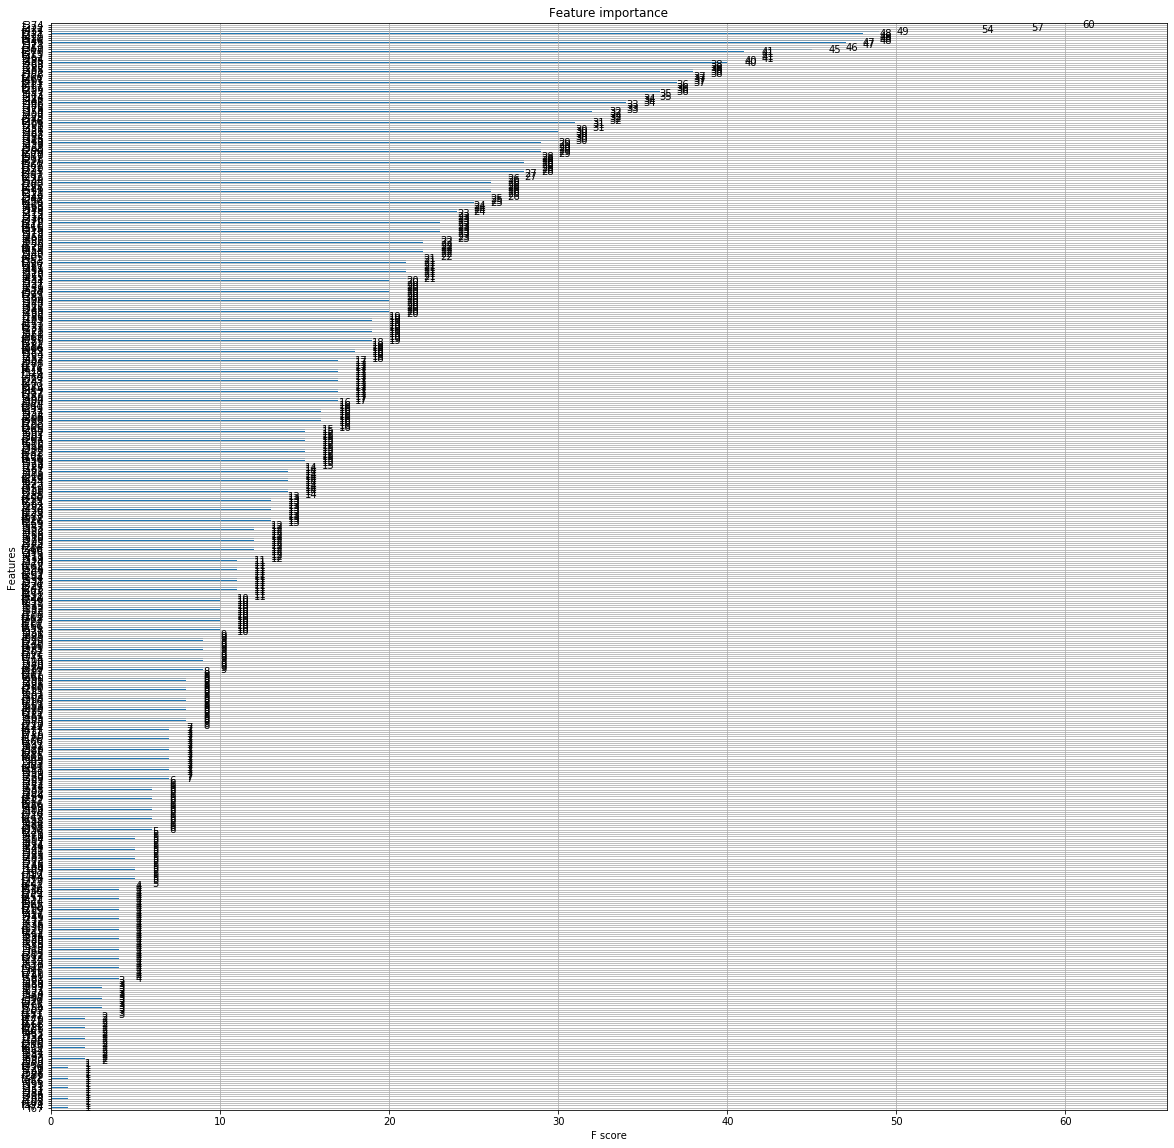

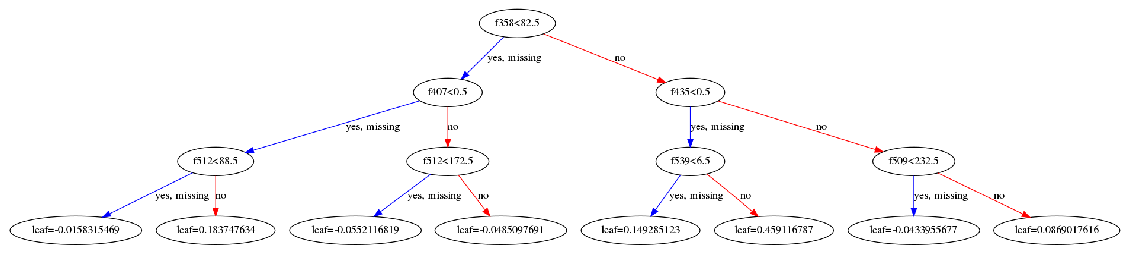

In [226]:
# when using xgboost, the data should be put into a Data Matrix structure, seen in
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix
D_train_784 = xgb.DMatrix(X_train_784,label=y_train_784)
D_test_784 = xgb.DMatrix(X_test_784,label=y_test_784)
params_XGBClassifier = {
    'booster':'gbtree',    
    'eta':0.1,
    'max_depth':3,
    'lambda':1,
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(D_test_784,'test'),(D_train_784,'train')]
num_round=100
stopping_rounds = 10
max_depth = 5

bst_784 = xgb.train(params_XGBClassifier,D_train_784,num_round,evallist,early_stopping_rounds=stopping_rounds)#,verbose_eval=False)

y_pred_784 = bst_784.predict(D_test_784)

print(accuracy_score(y_test_784,y_pred_784))
# plt.figure()
fig,ax = plt.subplots(figsize=(20,20))

xgb.plot_importance(bst_784,ax=ax)
plt.show()

fig,ax = plt.subplots(figsize=(20,20))
xgb.plot_tree(bst_784,num_trees=0,ax=ax)
plt.show()

### optimized

In [227]:
params_optimizing = {
    'booster':'gbtree',    
    'eta':0.9,
    'max_depth':2,
    'lambda':1,
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(D_test_784,'test'),(D_train_784,'train')]
num_round=100
stopping_rounds = 10
max_depth = 5

bst_784 = xgb.train(params_optimizing,D_train_784,num_round,evallist,early_stopping_rounds=stopping_rounds)#,verbose_eval=False)

y_pred =bst_784.predict(D_test_784)
print(np.shape(y_pred),np.shape(y_test_784))

[0]	test-merror:0.414143	train-merror:0.408804
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 10 rounds.
[1]	test-merror:0.2975	train-merror:0.287679
[2]	test-merror:0.253214	train-merror:0.245946
[3]	test-merror:0.214143	train-merror:0.204875
[4]	test-merror:0.192429	train-merror:0.184321
[5]	test-merror:0.176643	train-merror:0.170054
[6]	test-merror:0.162143	train-merror:0.155089
[7]	test-merror:0.153	train-merror:0.145018
[8]	test-merror:0.142214	train-merror:0.136018
[9]	test-merror:0.129143	train-merror:0.124804
[10]	test-merror:0.122214	train-merror:0.119179
[11]	test-merror:0.116929	train-merror:0.111625
[12]	test-merror:0.111	train-merror:0.106161
[13]	test-merror:0.105857	train-merror:0.101679
[14]	test-merror:0.101571	train-merror:0.096036
[15]	test-merror:0.097929	train-merror:0.0925
[16]	test-merror:0.095429	train-merror:0.09
[17]	test-merror:0.092857	train-merror:0.086446
[18]	test-m

(14000,)


,0,1,2,3,4,5,6,7,8,9
0,38,0,2,0,6,2,1,3,4,3
1,0,38,6,5,10,2,2,4,7,1
2,2,6,38,15,5,5,0,9,11,2
3,0,2,14,38,1,22,0,5,15,9
4,3,2,6,2,38,3,8,10,1,30
5,3,6,3,21,0,38,16,4,16,8
6,9,2,5,0,8,10,38,0,7,1
7,1,3,13,9,3,1,1,38,1,25
8,8,5,14,13,3,8,3,2,38,13
9,1,2,1,10,38,1,1,22,11,38


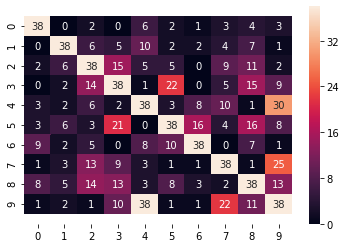

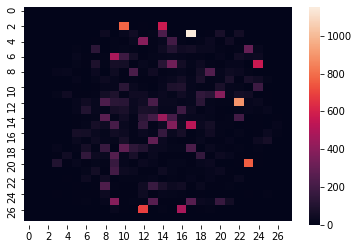

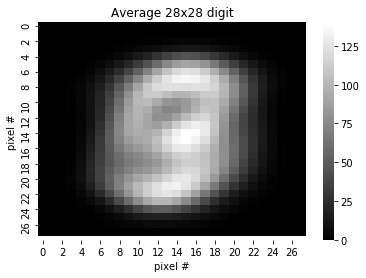

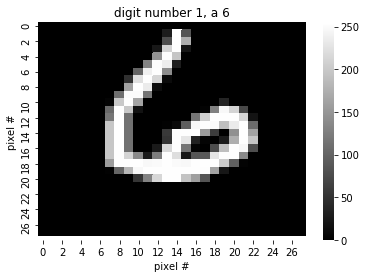

In [235]:
ape = confusion_matrix(y_pred,y_test_784.astype('int'))
df = pd.DataFrame(ape)
s(y_test_784)
np.fill_diagonal(df.values,0)
ultros=np.max(df)
bipp = np.max(ultros)
np.fill_diagonal(df.values,bipp)

display(df)
ax = sns.heatmap(df,annot=True)
bottom,top =ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.show()

a=bst_784.get_score(importance_type='gain')

for i in range(0,28*28): #fill dict
    if 'f'+str(i) not in a:
        a['f'+str(i)]=0

fisk = np.zeros(28*28)
for i in range(0,28*28):
    fisk[i] = a['f'+str(i)]

u=fisk.reshape(28,28)

plt.figure()
ax=sns.heatmap(u)
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.show()

XXX = X_train_784.mean(axis=0)
# s(XXX,X_train_784)
XX=XXX.reshape(28,28);
plt.figure()
ax=sns.heatmap(XX,cmap='binary_r')
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.xlabel('pixel #')
plt.ylabel('pixel #')
plt.title("Average 28x28 digit")
plt.show()

digit_n = 1
XXX = X_train_784[digit_n,:]
XX=XXX.reshape(28,28);
plt.figure()
ax=sns.heatmap(XX,cmap='binary_r')
first,second=ax.get_ylim()
ax.set_ylim(first+0.5,0)
plt.xlabel('pixel #')
plt.ylabel('pixel #')
plt.title("digit number {}, a {}".format(digit_n,int(y_train_784[digit_n])))
plt.show()

## PCA test large set

In [ ]:

#The counter is pretty stupid, but i'm just leaving it as is
test_accuracy_=[]
time_per_val = []
classifier_params = {
    'objective':'multi:softmax',
    'num_class':10,
}
num_round=100
early_stopping=10

aa = np.linspace(1,49,49)
bb = np.arange(50,800,50)
vals = np.hstack((aa,bb))
# for i in range(1,X_train_784.shape[1]):
for i in vals:
    print("{} of {}".format(int(i),len(vals)))
    n_comp = int(i)
    start = time.time()
    pca = PCA(n_components=n_comp)
    X2D = pca.fit_transform(X_train_784)
    X2Dt = pca.transform(X_test_784)
    D_train = xgb.DMatrix(X2D,label=y_train_784)
    D_test = xgb.DMatrix(X2Dt,label=y_test_784)
    evallist=[(D_train,'train'),(D_test,'test')]

    bst_784_pca=xgb.train(classifier_params,D_train,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
    y_pred=bst_784_pca.predict(D_test)
    time_per_val.append(time.time()-start)
    test_accuracy_.append(accuracy_score(y_test_784, y_pred))

plt.figure()
spl = 46
plt.semilogx(vals[:spl],time_per_val[:spl],'b')
plt.semilogx(vals[spl+2:],time_per_val[spl+2:],'b')

# plt.gca().invert_xaxis()
plt.title("PCA testing, time")
plt.xlabel("Number of features")
plt.ylabel("Training time [s]")
plt.show()

plt.figure()
plt.semilogx(vals,test_accuracy_)
# plt.gca().invert_xaxis()
plt.title("PCA testing")
plt.xlabel("Number of features")
plt.ylabel("Accuracy score")
plt.show()

seems 30 features should be enough.

In [238]:
n_comp=30

pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(X_train_784)
X2Dt = pca.transform(X_test_784)

model = XGBClassifier(objective='multi:softmax',num_class=10,random_state=42) #this uses binary:logistic by default.
start = time.time()
model.fit(X2D,y_train_784)
y_pred_classifier = model.predict(X2Dt)
print("This took {}s.".format(time.time()-start))
print("Accuracy: {}".format(accuracy_score(y_pred_classifier,y_test_784)))
# FULL HAS: 0.9342142857142857 accuracy

This took 123.37122774124146s.
Accuracy: 0.9048571428571428


In [243]:
# data = loadmat('mnist-original.mat')
# X_full = data['data'].T
# y_full = np.squeeze(data['label'].T)

mnist=fetch_openml('mnist_784')

X_full = mnist.data
y_full = mnist.target
# s(X_full,y_full)

test_size=0.2
X_train_,X_test_784,y_train_,y_test_784 = train_test_split(X_full,y_full,test_size=test_size,random_state=2)#,stratify=y)
X_train_784,X_val_784,y_train_784,y_val_784 = train_test_split(X_train_,y_train_,test_size=test_size,random_state=2)#,stratify=y)


n_comp=30

pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(X_train_784)
X2Dt = pca.transform(X_test_784)
X2Dv = pca.transform(X_val_784)

dX2D = xgb.DMatrix(X2D,y_train_784)
dX2Dt = xgb.DMatrix(X2Dt,y_test_784)
dX2Dv = xgb.DMatrix(X2Dv,y_val_784
                   )
classifier_params = {
    'objective':'multi:softmax',
    'num_class':10,
    'max_depth':4,
    'subsample':0.5,
#     'gamma':2,
#     'learning_rate':0.5,
#     'lambda':1,
#     'alpha':1,
    
}
evallist=[(dX2D,'train'),(dX2Dt,'test')]

num_round=1000
early_stopping=100
start = time.time()
# Set verbose_eval=True below to see train and test scores for each round.
bst=xgb.train(classifier_params,dX2D,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
y_pred=bst.predict(dX2Dt)
y_pred_val=bst.predict(dX2Dv)


print("This took {}s.".format(time.time()-start))
print("Accuracy: {}".format(accuracy_score(y_pred,y_test_784.astype('int'))))
print("Accuracy: {}".format(accuracy_score(y_pred_val,y_val_784.astype('int'))))

This took 820.310631275177s.
Accuracy: 0.972
Accuracy: 0.9716071428571429


,0,1,2,3,4,5,6,7,8,9
0,21,0,3,0,0,1,10,2,4,6
1,0,21,2,1,1,1,1,9,7,2
2,1,7,21,7,2,1,1,5,7,4
3,0,2,3,21,0,8,0,2,6,6
4,1,1,3,0,21,3,1,5,5,11
5,3,1,2,16,0,21,8,1,6,5
6,6,2,4,1,6,7,21,1,2,4
7,0,1,7,5,1,0,0,21,2,9
8,2,3,6,7,4,3,2,0,21,4
9,1,1,0,7,21,4,0,6,5,21


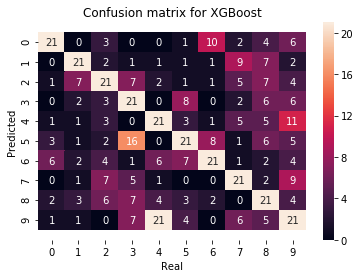

In [250]:
ape = confusion_matrix(y_pred_val,y_val_784.astype('int'))
df = pd.DataFrame(ape)
np.fill_diagonal(df.values,0)
ultros=np.max(df)
bipp = np.max(ultros)
np.fill_diagonal(df.values,bipp)

display(df)
ax = sns.heatmap(df,annot=True)
bottom,top =ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Confusion matrix for XGBoost')
plt.show()

In [245]:
model = XGBClassifier()
model.fit(X2D,y_train_784)
y_pred_classifier = model.predict(X2Dt)



accuracy_score(y_pred_classifier,y_test_784.astype('int'))

ting={'eval_metric':'merror'}
xgbc = XGBClassifier(
    n_estimators=400,
    booster='gbtree',
    objective='multi:softmax',
    num_class=10,
    **ting,
    random_state=42,
    )
start=time.time()
xgbc.fit(X2D,y_train_784)
scores=cross_val_score(xgbc,X2D,y_train_784,cv=10,n_jobs=-1)
print("this took {}s.".format(time.time()-start))
print("CV:",scores.mean())
print("test acc",xgbc.score(X2Dt,y_test_784))

this took 1757.1308424472809s.
CV: 0.9451118443501091
test acc 0.9487857142857142


In [247]:
n_comp=30

pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(X_train_784)
X2Dt = pca.transform(X_test_784)

dX2D = xgb.DMatrix(X2D,y_train_784)
dX2Dt = xgb.DMatrix(X2Dt,y_test_784)

classifier_params = {
    'max_depth':3,
    'learning_rate':0.1,
    'n_estimators':100,
    'booster':'gbtree',
    'tree_method':'auto',
    'n_jobs':1,
#     'gpu_id':-1,
    'gamma':0,
    'min_child_weight':1,
    'max_delta_step':0,
    'subsample':1,
    'colsample_bytree':1,
    'colsample_bylevel':1,
    'colsample_bynode':1,
    'reg_alpha':0,
    'reg_lambda':1,
    'scale_pos_weight':1,
    'base_score':0.5,
    'random_state':42,
    'missing':None,
#     'eta':0.1,
#     'max_depth':3,
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(dX2D,'train'),(dX2Dt,'test')]

num_round=100
early_stopping=10
start = time.time()
# Set verbose_eval=True below to see train and test scores for each round.
bst=xgb.train(classifier_params,dX2D,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
y_pred=bst.predict(dX2Dt)


print("This took {}s.".format(time.time()-start))
print("Accuracy: {}".format(accuracy_score(y_pred,y_test_784.astype('int'))))


This took 101.96460103988647s.
Accuracy: 0.9050714285714285


In [248]:
#starting with largeish jumps, then finetune after?
#not sure regularization matters? try after too? takes too long to test all
params_optimizing = {
    'eta':[0.1,0.01,0.001],
    'max_depth':[5,10,15],
    'gamma':[0.5,0.1],
}



xgbrf_model = XGBClassifier(objective='multi:softmax',num_class=10,random_state=42)
XGBRF_model = GridSearchCV(xgbrf_model,params_optimizing,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
XGBRF_model.fit(X2D,y_train_784)
print(XGBRF_model.best_score_)
print(XGBRF_model.best_params_)
y_pred = XGBRF_model.predict(X2Dt)
print("Accuracy score on test is {}".format(accuracy_score(y_pred,y_test_784.astype('int'))))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 117.8min finished


0.9498660714285714
{'eta': 0.1, 'gamma': 0.1, 'max_depth': 10}
Accuracy score on test is 0.0


## gridsearch

In [249]:
xgbrf_param={
    'max_depth': np.linspace(1,10,10).astype('int'),
    'n_estimators': np.linspace(50,400,50).astype('int'),
#     'reg_alpha':np.logspace(-7,1,9),
#     'reg_lambda': np.logspace(-7,1,9),
}
xgbrf_model = XGBRFClassifier(objective='multi:softmax',num_class=10,random_state=3)
XGBRF_model = GridSearchCV(xgbrf_model,xgbrf_param,scoring='accuracy',verbose=1,cv=5,n_jobs=-1)
XGBRF_model.fit(X_train,y_train)
print(XGBRF_model.best_score_)
print(XGBRF_model.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 58.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 61.5min finished


0.9345859429366736
{'max_depth': 7, 'n_estimators': 142}


## Gridsearch without skl

In [ ]:
n_comp=30

pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(X_train_784)
X2Dt = pca.transform(X_test_784)
X2Dv = pca.transform(X_val_784)

dX2D = xgb.DMatrix(X2D,y_train_784)
dX2Dt = xgb.DMatrix(X2Dt,y_test_784)
dX2Dv = xgb.DMatrix(X2Dv,y_val_784)

classifier_params = {
    'objective':'multi:softmax',
    'num_class':10,
}
evallist=[(dX2D,'train'),(dX2Dt,'test')]
# prams=[]
num_round=100
early_stopping=10

eta = [0.1,0.001,0.0001]
subsample = [0.5,1.0]
max_depth = [1,2,3,4,5]
gamma=[0,1,3,5]
accuracy0 = 0
for i,j,k,l in itertools.product(eta,subsample,max_depth,gamma):
    classifier_params['eta']=i
    classifier_params['subsample']=j
    classifier_params['max_depth']=k
    classifier_params['gamma']=l
    start = time.time()
    # Set verbose_eval=True below to see train and test scores for each round.
    bst=xgb.train(classifier_params,dX2D,num_round,evallist,early_stopping_rounds=early_stopping,verbose_eval=False)
    y_pred=bst.predict(dX2Dt)
    y_pred_val=bst.predict(dX2Dv)
    if accuracy_score(y_pred,y_test_784)>accuracy0:
        accuracy0 = accuracy_score(y_pred,y_test_784.astype('int'))
        vals = [i,j,k,l]
        test_acc = accuracy_score(y_pred_val,y_val_784.astype('int'))
print(accuracy0)
print(vals)
print(test_acc)